### Physics Informed DeepONet: Solving a ODE for different right hand sides
In this notebook, we present an introduction to the PI-DeepONet concept in TorchPhysics. 
As an example, we try to learn the integral operator of the ODE:
\begin{align*}
    \partial_t u(t) &= f(t), \text{ in } (0, 1) \\
    u(0) &= 0
\end{align*}
for different functions $f$. Since this a physics informed approach no data is requiered.

In [9]:
import torchphysics as tp 
import torch
import pytorch_lightning as pl

T = tp.spaces.R1("t") # trunk input
U = tp.spaces.R1("u") # solution
F = tp.spaces.R1("f") # branch input

branch_space = tp.spaces.FunctionSpace(T, F)

# Given that DeepONet are models that both get a functional and variable
# input, we also need to define an interval from which we will sample time points.
domain = tp.domains.Interval(T, 0, 1)
# We will sample 10 points in the interval [0, 1] and use them as the discretization
# points for the branch input.
time_grid = tp.samplers.GridSampler(domain, 10).sample_points().unsqueeze(0)

Next, we need to choose what functions we wnat to consider for the right-hand side. Here we combine different type of functions with the **CustomFunctionSet**:

In [10]:
def custom_fn(t, k):
    return k*t

def custom_fn_2(t, k):
    return k*t**2

def custom_fn_3(t, k):
    return k*torch.cos(t)

K = tp.spaces.R1("k") # parameter to sample for function set
param_sampler = tp.samplers.RandomUniformSampler(
    tp.domains.Interval(K, -1, 1), 10000
)

# The appending of functionsets lets us create a functionset with multiple functions
# that all are combined into one set.
custom_functionset = tp.domains.CustomFunctionSet(branch_space, param_sampler, custom_fn)
custom_functionset_2 = tp.domains.CustomFunctionSet(branch_space, param_sampler, custom_fn_2)
custom_functionset_3 = tp.domains.CustomFunctionSet(branch_space, param_sampler, custom_fn_3)
custom_functionset = custom_functionset.append(custom_functionset_2)
custom_functionset = custom_functionset.append(custom_functionset_3)

functionsampler = tp.samplers.FunctionSamplerRandomUniform(
        5000, custom_functionset, function_creation_interval=100
    )

In [11]:
# The model:
trunk_net = tp.models.FCTrunkNet(T, hidden=(10, 10), default_trunk_input=time_grid)
branch_net = tp.models.FCBranchNet(branch_space, hidden=(20, 20), grid=time_grid)
model = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons=20)

As in the PINN-approach we now define the residuals the DeepONet needs to fulfill. The only thing special is, that we
have to use the **PIDeepONetCondition**, since we also need to pass in a function sampler, that prepares the inputs of the branch net.

In [12]:
def ode_residual(u, t, f):
    return tp.utils.grad(u, t) - f

ode_sampler = tp.samplers.RandomUniformSampler(domain, 1000)

ode_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                             branch_function_sampler=functionsampler, 
                                             trunk_points_sampler=ode_sampler, 
                                             residual_fn=ode_residual)

In [13]:
boundary_sampler = tp.samplers.RandomUniformSampler(domain.boundary_left, 10)

def initial_residual(u):
    return u

initial_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                              branch_function_sampler=functionsampler, 
                                              trunk_points_sampler=boundary_sampler, 
                                              residual_fn=initial_residual)

In [14]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0005)

solver = tp.solver.Solver([ode_cond, initial_cond], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=5000, 
                     logger=False)

trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 1.4 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_worker

Epoch 0:   0%|          | 0/5000 [00:00<?, ?it/s] 

/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/functionsets/functionset_operations.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.current_idx = torch.tensor(idx, dtype=torch.long, device=self.device)


Epoch 0: 100%|██████████| 5000/5000 [03:15<00:00, 25.52it/s, train/loss=0.120] 

`Trainer.fit` stopped: `max_steps=5000` reached.


Epoch 0: 100%|██████████| 5000/5000 [03:15<00:00, 25.52it/s, train/loss=0.120]


torch.Size([1, 10, 1]) torch.Size([1, 1000, 1])


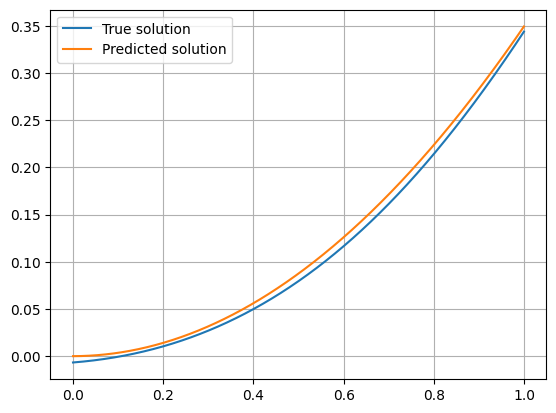

In [15]:
scale = 0.7
test_branch_input = (scale * time_grid.as_tensor)
test_trunk_input = tp.samplers.GridSampler(domain, 1000).sample_points().unsqueeze(0)
print(test_branch_input.shape, test_trunk_input.as_tensor.shape)
model_out = model(test_trunk_input, test_branch_input).as_tensor

import matplotlib.pyplot as plt
plt.plot(test_trunk_input.as_tensor[0], model_out.detach()[0])
plt.plot(test_trunk_input.as_tensor[0], scale/2.0*test_trunk_input.as_tensor[0]**2)
plt.legend(["True solution", "Predicted solution"])
plt.grid()